In [ ]:
!pip install librosa

In [ ]:
import os
import librosa
import pandas as pd
import seaborn as sns
import numpy as np

Для начала считываем инересующий нас файл
Если запись записана в стерео, то mono = False, чтоыб иметь возможность работать с двумя дорожками


In [ ]:
file_name = 'Phone.mp3'
y, sr = librosa.load(file_name, mono = False)

Параметр sr означает, что наш файл считался с частой дискретизации в 22050 Гц. Это значит что в данных будет 22050 значенйи амлитуды в секунду.


In [ ]:
sr

22050

Мы видим, что у нас двумерный массив, значит у нас две дорожки с 354750 значениями


In [ ]:
y.shape

(2, 643538)

Несложно посчитать общую длительность аудиозаписи, разделив общую длинную амлитуд на частоту дискретизации

In [ ]:
y.shape[1] / sr

16.08843537414966

Визуализация обеих дорожек

<Axes: >

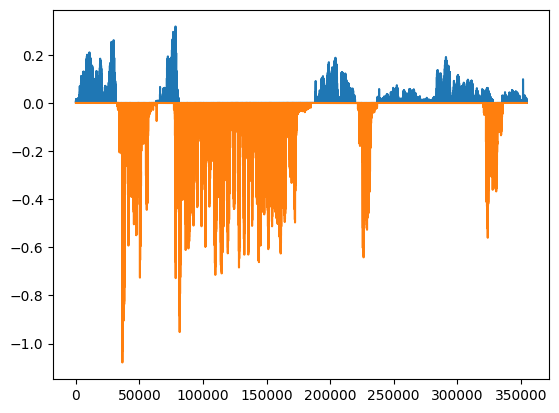

In [ ]:
sns.lineplot(abs(y[0]))
sns.lineplot(abs(y[1])*-1)

Первые 200 точек записи
Обращаю внимание, что большинство точек отличны от 0, но разговора в этот момент как такого не было.

<Axes: >

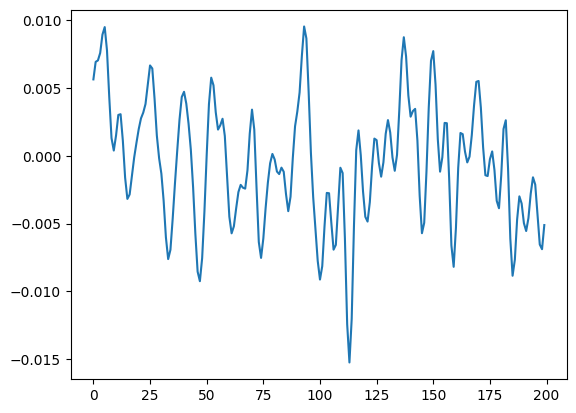

In [ ]:
sns.lineplot( y[0][:200] )

Поэтому для определение разговора, необходимо задать минимальный порог.
Далее выбираем из исходных данных только значения, подходящие под условие

In [ ]:
limit = 0.04
y0 = np.select([abs(y[0])>limit ],[1])
y1 = np.select([abs(y[1])>limit ],[-1])

Заполним все занчения в табличку
Заменяю 0 на Nan, чтобы остались только метки самих разговоров.
Добавим колонку времени, просто разделив индекс на sr, и получим занчение времени в каждый момент.

In [ ]:
df = pd.DataFrame( {'channel_1_orig':y[0]
                    ,'channel_2_orig':y[1]
                    ,'channel_1':abs(y[0])
                    ,'channel_2':abs(y[1])*-1
                    ,'channel_1_limit':y0
                    ,'channel_2_limit':y1})
df['time'] = df.index / sr

In [ ]:
df['channel_1_limit'] = df['channel_1_limit'].replace(0,np.nan)
df['channel_2_limit'] = df['channel_2_limit'].replace(0,np.nan)

In [ ]:
df

,channel_1_orig,channel_2_orig,channel_1,channel_2,channel_1_limit,channel_2_limit,time,channel_1_limit_new,channel_2_limit_new
0,0.005640,0.0,0.005640,-0.0,NaN,NaN,0.000000,NaN,NaN
1,0.006935,0.0,0.006935,-0.0,NaN,NaN,0.000045,NaN,NaN
2,0.007041,0.0,0.007041,-0.0,NaN,NaN,0.000091,NaN,NaN
3,0.007594,0.0,0.007594,-0.0,NaN,NaN,0.000136,NaN,NaN
4,0.008946,0.0,0.008946,-0.0,NaN,NaN,0.000181,NaN,NaN
...,...,...,...,...,...,...,...,...,...
354745,-0.009929,0.0,0.009929,-0.0,NaN,NaN,16.088209,NaN,NaN
354746,-0.011475,0.0,0.011475,-0.0,NaN,NaN,16.088254,NaN,NaN
354747,-0.011519,0.0,0.011519,-0.0,NaN,NaN,16.088299,NaN,NaN
354748,-0.008900,0.0,0.008900,-0.0,NaN,NaN,16.088345,NaN,NaN


И вроде, судя по графику, мы получили желаемый результат.

<Axes: xlabel='time', ylabel='channel_1'>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


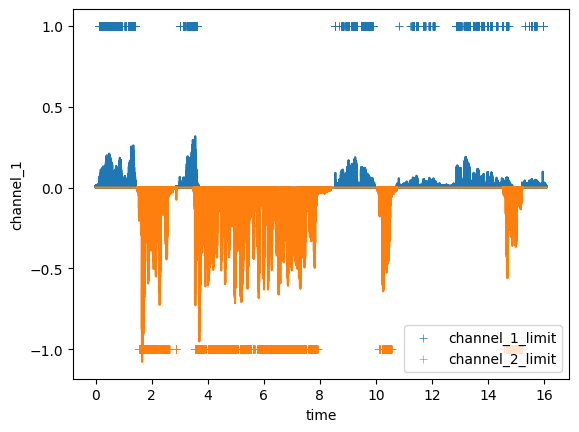

In [ ]:
sns.lineplot(data = df, x = 'time', y = 'channel_1')
sns.lineplot(data = df, x = 'time', y = 'channel_2')
sns.scatterplot(data = df, x = 'time', y = 'channel_1_limit',label = 'channel_1_limit',marker = '+')
sns.scatterplot(data = df, x = 'time', y = 'channel_2_limit',label = 'channel_2_limit',marker = '+')

Но если мы посчитаем длительность размеченных разговоров, то получим
суммарно 4.6 секнды, что явно не соотвествует действительнсоти.

In [ ]:
len(df[~df.channel_1_limit.isna()]) / sr + len(df[~df.channel_2_limit.isna()])/ sr

4.602267573696145

Связано это с тем, что во время разговора синусоида множество раз пересекает 0 (это зависит от частоты голоса), и соответственно значение амплитуды опускается ниже порога.
На графике видно, что идет разговор, но не везде он помечен как разговор.
Из-за этого можем терять до половниы времени всего разговора.

In [ ]:
def plot_part(time_start,chanel,dur = 0.02, new = ''):
    time_end = time_start + dur
    df_plt = df[(df.time>time_start)&(df.time<time_end)]
    sns.lineplot(data = df_plt, x = 'time', y = f'{chanel}_orig')
    sns.scatterplot(data = df_plt, x = 'time', y = f'{chanel}_limit{new}',label = 'speech',marker = '|')
    print('loss',len(df[(df.time>time_start)&(df.time<time_end)&(df[f'{chanel}_limit{new}'].isna())]) / len(df[(df.time>time_start)&(df.time<time_end)]))

loss 0.4318181818181818


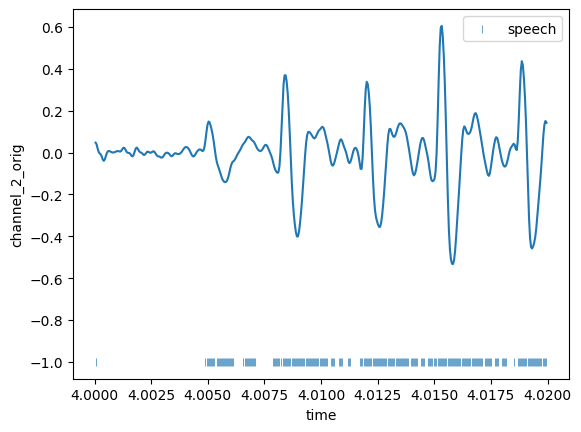

In [ ]:
plot_part(4,'channel_2')

Попробую исправить это.
Исходя из предположения, что если в момент был разговор, то и следующие 0.1 секунды разговор был (в нашем случае следующие 2205 точек).

In [ ]:
points = int( 0.1 * sr )
df['channel_1_limit_new'] = df['channel_1_limit'].fillna(method = 'ffill',limit = points)
df['channel_2_limit_new'] = df['channel_2_limit'].fillna(method = 'ffill',limit = points)

loss 0.0


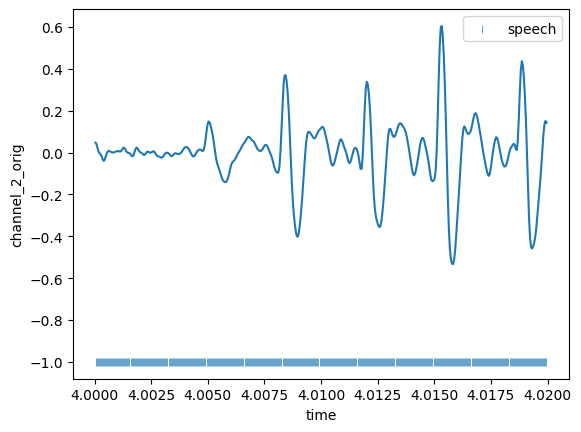

In [ ]:
plot_part(4,'channel_2',new = '_new')

После выполненных выше преобразований, получаем общую длительность разговора ~ 14 секунд, что уже похоже на правду.

In [ ]:
len(df[~df.channel_1_limit_new.isna()]) / sr + len(df[~df.channel_2_limit_new.isna()])/ sr

13.95891156462585

<Axes: xlabel='time', ylabel='channel_1'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


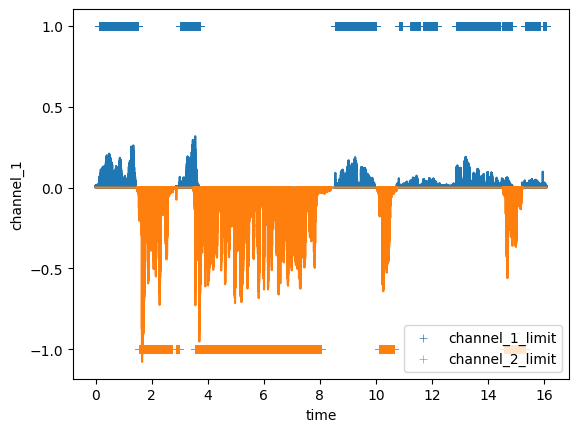

In [ ]:
sns.lineplot(data = df, x = 'time', y = 'channel_1')
sns.lineplot(data = df, x = 'time', y = 'channel_2')
sns.scatterplot(data = df, x = 'time', y = 'channel_1_limit_new',label = 'channel_1_limit',marker = '+')
sns.scatterplot(data = df, x = 'time', y = 'channel_2_limit_new',label = 'channel_2_limit',marker = '+')

Чтобы найти время, в которое в обоих каналах шел разговор, просто найдем где метки не пустые одновременно.

In [ ]:
len(df[~df.channel_1_limit_new.isna()&~df.channel_2_limit_new.isna()])/ sr

0.47750566893424035

В заключение сформируем отчет, если понадобится обрабатывать множество файлов.

In [ ]:
df_add = pd.DataFrame({'file_name':file_name,
                       'total_duration':len(df)/sr,
                       'channel_1_duration':len(df[~df.channel_1_limit_new.isna()]) / sr,
                       'channel_2_duration':len(df[~df.channel_2_limit_new.isna()]) / sr,
                       'channel_1_2_duration':len(df[~df.channel_1_limit_new.isna()&~df.channel_2_limit_new.isna()])/ sr
                       },index = [0])

df_add

,file_name,total_duration,channel_1_duration,channel_2_duration,channel_1_2_duration
0,Phone.mp3,16.088435,6.852109,7.106803,0.477506


https://github.com/ermakovichmn/Librosa_AMP